# Word Embeddings
In this notebook, we will implement the Skip-Gram model using pytorch, import GloVe embeddings and end with prediction using again the CoronaNLP dataset.

## Word2vec - the Skip-Gram model


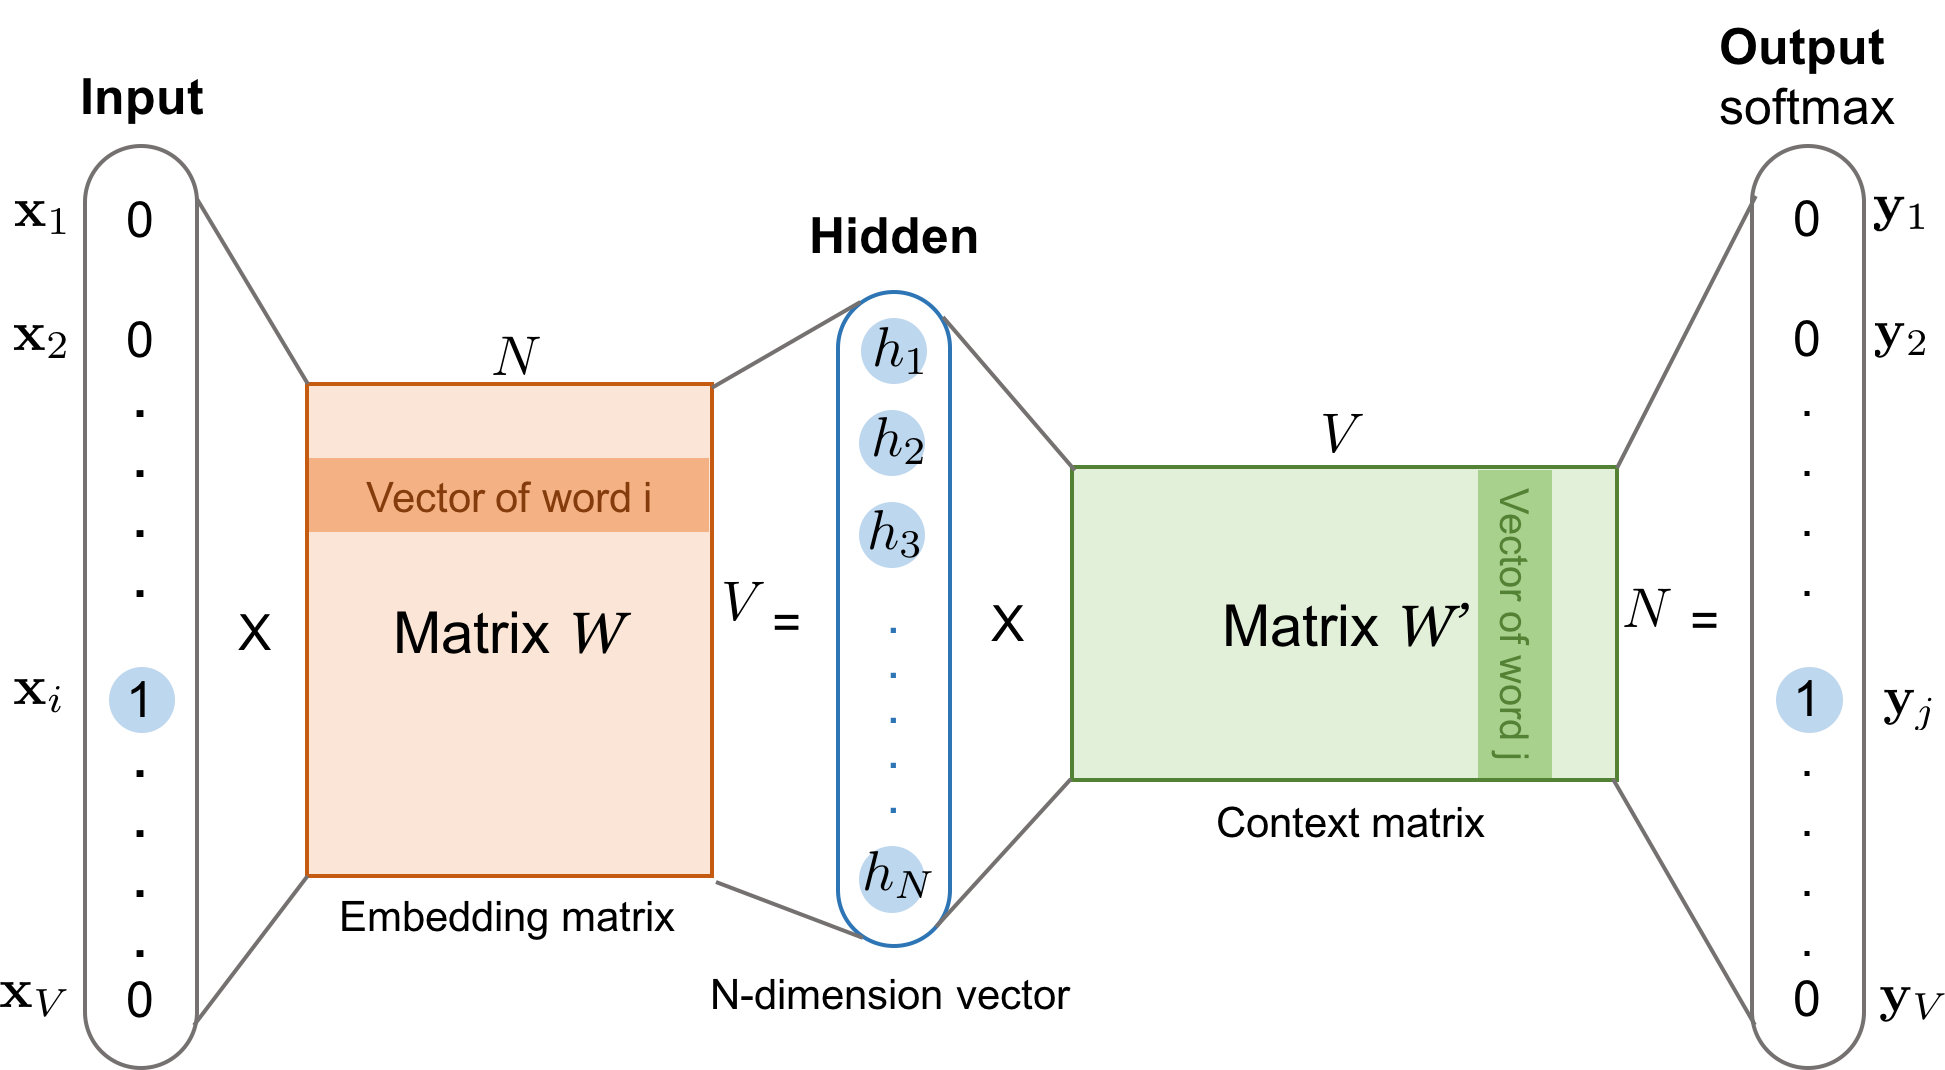

**NOTE:** This notebook requires you to install pytorch. If you have a NVIDIA GPU and want to use it to accelerate tensor computation use this link: https://pytorch.org/get-started/locally/ and follow the instructions. Else, a simple pip install torch should suffice.

In [6]:
#!pip install torch 

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import pandas as pd
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

Let's start with a simple corpus:

In [8]:
corpus = [
    'he is a king',
    'she is a queen',
    'she is mad',
    'she is in love',
    'a mountain falls',
    'paris is france capital',   
]

In [9]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

In [10]:
tokenized_corpus = tokenize_corpus(corpus)

In [11]:
tokenized_corpus

[['he', 'is', 'a', 'king'],
 ['she', 'is', 'a', 'queen'],
 ['she', 'is', 'mad'],
 ['she', 'is', 'in', 'love'],
 ['a', 'mountain', 'falls'],
 ['paris', 'is', 'france', 'capital']]

In [12]:
vocabulary = {word for doc in tokenized_corpus for word in doc}

In [13]:
vocabulary

{'a',
 'capital',
 'falls',
 'france',
 'he',
 'in',
 'is',
 'king',
 'love',
 'mad',
 'mountain',
 'paris',
 'queen',
 'she'}

In [14]:
word2idx = {w:idx for (idx, w) in enumerate(vocabulary)}

In [15]:
word2idx

{'queen': 0,
 'falls': 1,
 'is': 2,
 'capital': 3,
 'king': 4,
 'a': 5,
 'mountain': 6,
 'paris': 7,
 'france': 8,
 'love': 9,
 'he': 10,
 'she': 11,
 'mad': 12,
 'in': 13}

As you have seen in the theoretical lesson, we want to build pairs of words that appear within the same context.

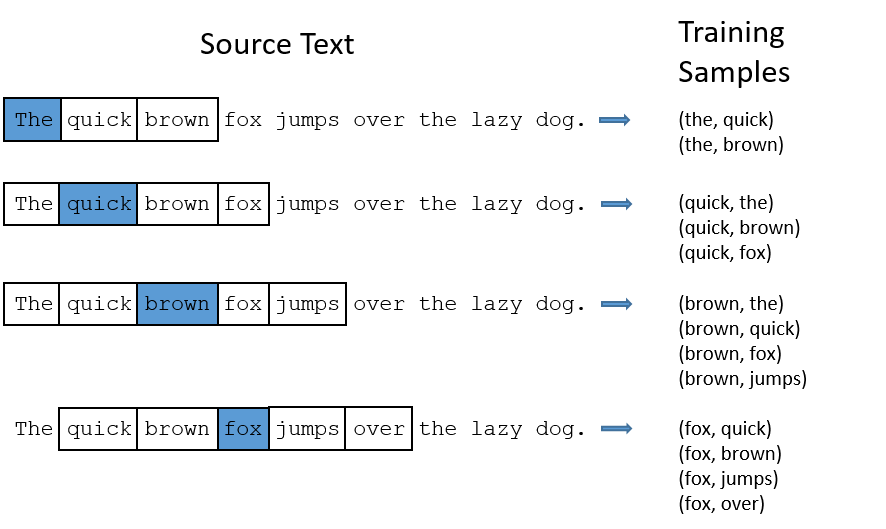

In [16]:
def build_training(tokenized_corpus, word2idx, window_size=2):
    idx_pairs = []
    
    # for each sentence
    for sentence in tokenized_corpus:
        indices = [word2idx[word] for word in sentence]
        # for each word, treated as center word
        for center_word_pos in range(len(indices)):
            # for each window position
            for w in range(-window_size, window_size + 1):
                context_word_pos = center_word_pos + w
                # make sure not jump out sentence
                if  context_word_pos < 0 or \
                    context_word_pos >= len(indices) or \
                    center_word_pos == context_word_pos:
                    continue  
                context_word_idx = indices[context_word_pos]
                idx_pairs.append((indices[center_word_pos], context_word_idx))
    return np.array(idx_pairs)

In [17]:
training_pairs = build_training(tokenized_corpus, word2idx)

In [18]:
training_pairs

array([[10,  2],
       [10,  5],
       [ 2, 10],
       [ 2,  5],
       [ 2,  4],
       [ 5, 10],
       [ 5,  2],
       [ 5,  4],
       [ 4,  2],
       [ 4,  5],
       [11,  2],
       [11,  5],
       [ 2, 11],
       [ 2,  5],
       [ 2,  0],
       [ 5, 11],
       [ 5,  2],
       [ 5,  0],
       [ 0,  2],
       [ 0,  5],
       [11,  2],
       [11, 12],
       [ 2, 11],
       [ 2, 12],
       [12, 11],
       [12,  2],
       [11,  2],
       [11, 13],
       [ 2, 11],
       [ 2, 13],
       [ 2,  9],
       [13, 11],
       [13,  2],
       [13,  9],
       [ 9,  2],
       [ 9, 13],
       [ 5,  6],
       [ 5,  1],
       [ 6,  5],
       [ 6,  1],
       [ 1,  5],
       [ 1,  6],
       [ 7,  2],
       [ 7,  8],
       [ 2,  7],
       [ 2,  8],
       [ 2,  3],
       [ 8,  7],
       [ 8,  2],
       [ 8,  3],
       [ 3,  2],
       [ 3,  8]])

In [20]:
def get_onehot_vector(word_idx, vocabulary):
    x = torch.zeros(len(vocabulary)).float()
    x[word_idx] = 1.0
    return x

def Skip_Gram(training_pairs, vocabulary, embedding_dims=5, learning_rate=0.001, epochs=10):
    
    torch.manual_seed(3)
    
    W1 = torch.randn(embedding_dims, len(vocabulary), requires_grad=True).float()
    W2 = torch.randn(len(vocabulary), embedding_dims, requires_grad=True).float()
    
    losses = []
    
    for epo in tqdm(range(epochs)):
        loss_val = 0
        
        for input_word, target in training_pairs:
            x = get_onehot_vector(input_word, vocabulary).float()
            y_true = torch.from_numpy(np.array([target])).long()

            # Matrix multiplication to obtain the input word embedding
            z1 = torch.matmul(W1, x)
    
            # Matrix multiplication to obtain the z score for each word
            z2 = torch.matmul(W2, z1)
    
            # Apply Log and softmax functions
            log_softmax = F.log_softmax(z2, dim=0) # Applies a softmax followed by a logarithm.
            
            # Compute the negative-log-likelihood loss
            loss = F.nll_loss(log_softmax.view(1,-1), y_true) # .view -> Returns a tensor with the same data but with a different shape.
            loss_val += loss.item() # -item -> Returns the value of this tensor as a standard Python number.
            
            # Compute the gradient in function of the error
            loss.backward() 
            
            # Update your embeddings
            W1.data -= learning_rate * W1.grad.data
            W2.data -= learning_rate * W2.grad.data

            W1.grad.data.zero_() 
            W2.grad.data.zero_()
            
            # .grad -> This attribute is None by default and becomes a Tensor the first time a call to backward()
            #computes gradients. The attribute will then contain the gradients computed and future 
            #calls to backward() will accumulate (add) gradients into it.
        
        losses.append(loss_val/len(training_pairs))
    
    return W1, W2, losses

In [21]:
W1, W2, losses = Skip_Gram(training_pairs, word2idx, epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
def plot_loss(loss):
    x_axis = [epoch+1 for epoch in range(len(loss))]
    plt.plot(x_axis, loss, '-g', linewidth=1, label='Train')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.show()

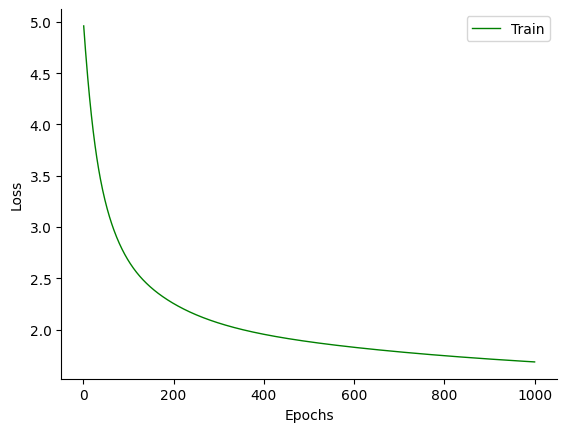

In [23]:
plot_loss(losses)

### Final Embedding Matrix

The Skip-Gram model can be implemented in 2 different ways:

- With shared parameters, meaning that, $W_1$ and $W_2$ are the same matrix.
- Without shared paramenters across layers, meaning that, in the end, we have two different matrixes with weights. The final matrix $W$ is the average of both matrixes.

In [24]:
W = W1 + torch.t(W2)
W = (torch.t(W)/2).clone().detach()

In [25]:
W[word2idx["she"]], W[word2idx["mad"]]

(tensor([ 0.9332,  0.9387,  0.3914, -0.7153, -0.5616]),
 tensor([ 0.3405,  0.8772,  0.3258, -0.8496, -1.0004]))

In [26]:
from sklearn.metrics.pairwise import euclidean_distances

euclidean_distances([W[word2idx["she"]].numpy()], [W[word2idx["falls"]].numpy()])

array([[1.9932]], dtype=float32)

In [27]:
euclidean_distances([W[word2idx["she"]].numpy()], [W[word2idx["mad"]].numpy()])

array([[0.7549507]], dtype=float32)

As you can see from the previous example the vector representing "she" and the vector representing "mad" are closer then the vector representing "she" and "falls". This happens because "she" and "falls" never appear together inside the same context window.

Now, we will change the Skip-Gram function in order to have only 1 matrix of weights instead of 2, and run the training again.

In [28]:
def Skip_Gram(training_pairs, vocabulary, embedding_dims=5, learning_rate=0.001, epochs=10):
    
    torch.manual_seed(3)
    
    W1 = torch.randn(embedding_dims, len(vocabulary), requires_grad=True).float()
    
    losses = []
    
    for epo in tqdm(range(epochs)):
        loss_val = 0
        
        for input_word, target in training_pairs:
            x = get_onehot_vector(input_word, vocabulary).float()
            y_true = torch.from_numpy(np.array([target])).long()

            # Matrix multiplication to obtain the input word embedding
            z1 = torch.matmul(W1, x)
    
            # Matrix multiplication to obtain the z score for each word
            z2 = torch.matmul(z1, W1)
    
            # Apply Log and softmax functions
            log_softmax = F.log_softmax(z2, dim=0)
            
            # Compute the negative-log-likelihood loss
            loss = F.nll_loss(log_softmax.view(1,-1), y_true)
            loss_val += loss.item()
            
            # Compute the gradient in function of the error
            loss.backward() 
            
            # Update your embeddings
            W1.data -= learning_rate * W1.grad.data
            
            W1.grad.data.zero_()
        
        losses.append(loss_val/len(training_pairs))
    
    return W1, losses

In [29]:
W1, losses = Skip_Gram(training_pairs, word2idx, epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

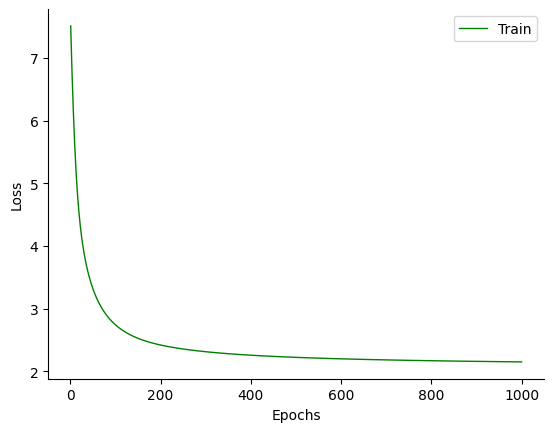

In [30]:
plot_loss(losses)

In [31]:
W = torch.t(W1).clone().detach()

In [32]:
W[word2idx["she"]], W[word2idx["mad"]]

(tensor([-0.5616,  0.8542,  0.3972, -0.8998,  1.0256]),
 tensor([-0.2395,  0.9689,  0.0633, -1.0699,  0.3244]))

In [33]:
from sklearn.metrics.pairwise import euclidean_distances

euclidean_distances([W[word2idx["she"]].numpy()], [W[word2idx["falls"]].numpy()])

array([[2.498064]], dtype=float32)

In [34]:
euclidean_distances([W[word2idx["she"]].numpy()], [W[word2idx["mad"]].numpy()])

array([[0.8654451]], dtype=float32)

### Word Embeddings Visualization

Go to https://projector.tensorflow.org/ and visualize Word2Vec embeddings. 

Original Word2Vec repository: https://code.google.com/archive/p/word2vec/

## Exploring Word Vectors with GloVe

As we have seen, the Word2vec algorithms (such as Skip-Gram) predicts words in a context (e.g. what is the most likely word to appear in "the cat ? the mouse"). GloVe vectors are based on global counts across the corpus.  

The advantage of GloVe is that, unlike Word2vec, GloVe does not rely just on local statistics (local context information of words), but incorporates global statistics (word co-occurrence) to obtain word vectors — see [How is GloVe different from word2vec?](https://www.quora.com/How-is-GloVe-different-from-word2vec) and [Intuitive Guide to Understanding GloVe Embeddings](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010)  for some better explanations.

Multiple sets of pre-trained GloVe vectors are easily available for [download](https://nlp.stanford.edu/projects/glove/), so that's what we'll use here.

Part of this section is taken from [practical-pytorch tutorials](https://github.com/spro/practical-pytorch/blob/master/glove-word-vectors/glove-word-vectors.ipynb)

### Loading word vectors

Torchtext includes functions to download GloVe (and other) embeddings

In [35]:
#!pip install torchtext==0.6.0

In [1]:
import torch
import torchtext.vocab as vocab

In [2]:
glove = vocab.GloVe(name='6B', dim=50)
print('Loaded {} words'.format(len(glove.itos)))

Loaded 400000 words


Loaded 400000 words.

The returned GloVe object includes attributes:

- `stoi` - string-to-index - returns a dictionary of words to indexes.
- `itos` - index-to-string - returns an array of words by index.
- `vectors`- returns the actual vectors. 

To get a word vector get the index to get the vector:

In [3]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]

### Finding the closest vectors

Here, we're calculating the distance for each word in the vocabulary, and sorting based on that distance:

In [4]:
def closest(vec, n=10):
    """
    Find the closest words for a given vector
    """
    all_dists = [(w, torch.dist(vec, get_word(w))) for w in tqdm(glove.itos)]
    return sorted(all_dists, key=lambda t: t[1])[:n]

In [7]:
closest(get_word('google'))

  0%|          | 0/400000 [00:00<?, ?it/s]

[('google', tensor(0.)),
 ('yahoo', tensor(2.3412)),
 ('aol', tensor(2.8021)),
 ('microsoft', tensor(3.1196)),
 ('facebook', tensor(3.1771)),
 ('web', tensor(3.2440)),
 ('ebay', tensor(3.2447)),
 ('netscape', tensor(3.3700)),
 ('internet', tensor(3.4071)),
 ('msn', tensor(3.4756))]

This will return a list of (word, distance) tuple pairs. Here's a helper function to print that list:

In [8]:
def print_tuples(tuples):
    for tuple in tuples:
        print('(%.4f) %s' % (tuple[1], tuple[0]))

In [9]:
print_tuples(closest(get_word('google')))

  0%|          | 0/400000 [00:00<?, ?it/s]

(0.0000) google
(2.3412) yahoo
(2.8021) aol
(3.1196) microsoft
(3.1771) facebook
(3.2440) web
(3.2447) ebay
(3.3700) netscape
(3.4071) internet
(3.4756) msn


### Word analogies with vector arithmetic
The most interesting feature of a well-trained word vector space is that certain semantic relationships (beyond just closeness of words) can be captured with regular vector arithmetic.

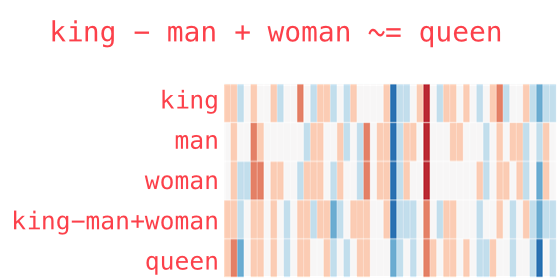


(image borrowed from https://jalammar.github.io/illustrated-word2vec/)

Read [The Illustrated Word2vec](https://jalammar.github.io/illustrated-word2vec/) for more information.

In [10]:
def analogy(w1, w2, w3, n=5, filter_given=True):
    # w2 - w1 + w3 = w4
    closest_words = closest(get_word(w2) - get_word(w1) + get_word(w3))
    print('\n[%s - %s + %s = ?]' % (w1, w2, w3))
    # Optionally filter out given words
    if filter_given:
        closest_words = [t for t in closest_words if t[0] not in [w1, w2, w3]]
        
    print_tuples(closest_words[:n])

In [11]:
analogy('king', 'man', 'queen')

  0%|          | 0/400000 [00:00<?, ?it/s]


[king - man + queen = ?]
(2.8391) woman
(3.3545) girl
(3.9518) boy
(4.0233) her
(4.0554) herself


Now let's explore the word space and see what stereotypes we can uncover:

In [45]:
analogy('man', 'actor', 'woman')
analogy('cat', 'kitten', 'dog')
analogy('dog', 'puppy', 'cat')
analogy('russia', 'moscow', 'france')
analogy('obama', 'president', 'trump')
analogy('rich', 'mansion', 'poor')
analogy('elvis', 'rock', 'eminem')
analogy('paper', 'newspaper', 'screen')
analogy('monet', 'paint', 'michelangelo')
analogy('beer', 'barley', 'wine')
analogy('earth', 'moon', 'sun')
analogy('house', 'roof', 'castle')
analogy('building', 'architect', 'software')
analogy('boston', 'bruins', 'phoenix')
analogy('good', 'heaven', 'bad')
analogy('jordan', 'basketball', 'woods')

  0%|          | 0/400000 [00:00<?, ?it/s]


[man - actor + woman = ?]
(2.0527) actress
(3.6065) starred
(3.8781) comedian
(3.9407) starring
(3.9920) entertainer


  0%|          | 0/400000 [00:00<?, ?it/s]


[cat - kitten + dog = ?]
(3.0314) puppy
(3.2785) rottweiler
(3.5163) spunky
(3.5478) toddler
(3.5482) mannequin


  0%|          | 0/400000 [00:00<?, ?it/s]


[dog - puppy + cat = ?]
(3.0314) kitten
(3.0836) puppies
(3.2215) pug
(3.2300) frisky
(3.2628) tarantula


  0%|          | 0/400000 [00:00<?, ?it/s]


[russia - moscow + france = ?]
(2.5632) paris
(3.5555) strasbourg
(3.8609) brussels
(3.9079) lyon
(3.9367) marseille


  0%|          | 0/400000 [00:00<?, ?it/s]


[obama - president + trump = ?]
(5.1069) debartolo
(5.1298) bally
(5.1754) ebbers
(5.1826) harrah
(5.2083) petronas


  0%|          | 0/400000 [00:00<?, ?it/s]


[rich - mansion + poor = ?]
(4.4530) bungalow
(4.7109) apartment
(4.7145) residence
(4.7241) dormitory
(4.7605) dilapidated


  0%|          | 0/400000 [00:00<?, ?it/s]


[elvis - rock + eminem = ?]
(4.5673) rap
(5.1407) hip-hop
(5.1510) rappers
(5.2317) hop
(5.2441) rapper


  0%|          | 0/400000 [00:00<?, ?it/s]


[paper - newspaper + screen = ?]
(3.4250) tv
(3.5702) television
(4.0667) broadcast
(4.1467) radio
(4.2523) audience


  0%|          | 0/400000 [00:00<?, ?it/s]


[monet - paint + michelangelo = ?]
(4.7947) molded
(4.8189) microscope
(4.9944) stained
(4.9970) handwriting
(5.0162) plaster


  0%|          | 0/400000 [00:00<?, ?it/s]


[beer - barley + wine = ?]
(4.1063) grape
(4.4254) legumes
(4.4577) grapes
(4.4731) varieties
(4.5731) beans


  0%|          | 0/400000 [00:00<?, ?it/s]


[earth - moon + sun = ?]
(4.9071) chung
(4.9905) chan
(4.9941) myung
(4.9970) ho
(5.0008) kim


  0%|          | 0/400000 [00:00<?, ?it/s]


[house - roof + castle = ?]
(4.7628) moat
(4.9241) fortress
(5.0980) tower
(5.1121) stonework
(5.1523) battlements


  0%|          | 0/400000 [00:00<?, ?it/s]


[building - architect + software = ?]
(4.4894) programmer
(4.7926) inventor
(5.2666) explorer
(5.2762) innovator
(5.3507) pioneered


  0%|          | 0/400000 [00:00<?, ?it/s]


[boston - bruins + phoenix = ?]
(2.5751) celtics
(2.6327) mavericks
(2.6589) mavs
(2.6967) suns
(2.7843) lakers


  0%|          | 0/400000 [00:00<?, ?it/s]


[good - heaven + bad = ?]
(3.2037) hell
(3.6382) curse
(3.7827) eternity
(3.8168) ghosts
(3.8482) madness


  0%|          | 0/400000 [00:00<?, ?it/s]


[jordan - basketball + woods = ?]
(5.2863) golf
(5.5034) gators
(5.7383) championship
(5.8291) pga
(5.8761) nicklaus


## Prediction

In [65]:
df = pd.read_csv("Corona_NLP.csv", encoding='latin-1')
pd.options.display.max_colwidth = 500
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive
2,3801,48753,Vagabonds,16-03-2020,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive
3,3802,48754,NaN,16-03-2020,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,"As news of the regionÂs first confirmed COVID-19 case came out of Sullivan County last week, people flocked to area stores to purchase cleaning supplies, hand sanitizer, food, toilet paper and other goods, @Tim_Dodson reports https://t.co/cfXch7a2lU",Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,"Cashier at grocery store was sharing his insights on #Covid_19 To prove his credibility he commented ""I'm in Civics class so I know what I'm talking about"". https://t.co/ieFDNeHgDO",Positive
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toilet paper. #Rebel\r\r\n\r\r\n#toiletpapercrisis #covid_19 https://t.co/eVXkQLIdAZ,Neutral
8,3807,48759,"Atlanta, GA USA",16-03-2020,"Due to COVID-19 our retail store and classroom in Atlanta will not be open for walk-in business or classes for the next two weeks, beginning Monday, March 16. We will continue to process online and phone orders as normal! Thank you for your understanding! https://t.co/kw91zJ5O5i",Positive
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy things with the cash and should use online payment methods because corona can spread through the notes. Also we should prefer online shopping from our home. It's time to fight against COVID 19?. #govindia #IndiaFightsCorona",Negative


In [66]:
df  = df[['OriginalTweet', 'Sentiment']].head(10000)

In [67]:
set(df['Sentiment'].values)

{'Extremely Negative', 'Extremely Positive', 'Negative', 'Neutral', 'Positive'}

In [68]:
df['LabelSentiment'] = df['Sentiment'].apply(lambda x: 1 if x in ['Extremely Positive', 'Positive', 'Neutral'] else 0)

In [69]:
df.head()

,OriginalTweet,Sentiment,LabelSentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8,Neutral,1
1,advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order,Positive,1
2,"Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P",Positive,1
3,"My food stock is not the only one which is empty...\r\r\n\r\r\nPLEASE, don't panic, THERE WILL BE ENOUGH FOOD FOR EVERYONE if you do not take more than you need. \r\r\nStay calm, stay safe.\r\r\n\r\r\n#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j",Positive,1
4,"Me, ready to go at supermarket during the #COVID19 outbreak.\r\r\n\r\r\nNot because I'm paranoid, but because my food stock is litteraly empty. The #coronavirus is a serious thing, but please, don't panic. It causes shortage...\r\r\n\r\r\n#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n",Extremely Negative,0


In [70]:
X_train, X_test, y_train, y_test = train_test_split(df['OriginalTweet'], df['LabelSentiment'], test_size=0.20, random_state=4)

In [71]:
len(X_train), len(X_test), len(y_train), len(y_test)

(8000, 2000, 8000, 2000)

### Clean text

In [72]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [73]:
def clean(text_list):
    
    updates = []
    
    for j in tqdm(text_list):
        
        text = j
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        
        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
        #Lemmatize
        text = " ".join(lemma.lemmatize(word) for word in text.split())
            
        updates.append(text)
        
    return updates

In [125]:
X_train_clean = clean(X_train)

  0%|          | 0/8000 [00:00<?, ?it/s]

In [126]:
X_test_clean = clean(X_test)

  0%|          | 0/2000 [00:00<?, ?it/s]

### Define training features - Word2vec

In [127]:
#!pip install gensim
import gensim.downloader

In [128]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [129]:
#300 indicates the embedding size
w2v = gensim.downloader.load('word2vec-google-news-300')

In [130]:
emb_size = 300

In [131]:
#function to get embeddings for each word based on w2v list
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        #get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in w2v.index_to_key:
                doc_vectors.append(w2v.get_vector(word))         
        corpus_vec.append(doc_vectors)
    return corpus_vec

In [132]:
x_train_vec = corpus2vec(X_train_clean)

  0%|          | 0/8000 [00:00<?, ?it/s]

In [133]:
x_test_vec = corpus2vec(X_test_clean)

  0%|          | 0/2000 [00:00<?, ?it/s]

#### Get sentence embeddings

A simple way to get sentence embeddings is through averaging word embedding representations, which we will use today. Still, there are more robust alternatives including Doc2Vec and transformer-based embeddings (the latter will be taught in a future notebook).

In [134]:
import tensorflow as tf

In [135]:
x_mean_train=[]
for doc in x_train_vec:
    x_mean_train.append(np.mean(doc,axis=0))

In [136]:
x_mean_train=tf.convert_to_tensor(x_mean_train, dtype='float32')
print(x_mean_train.shape)

(8000, 300)


In [137]:
y_train[0:10]

4983    1
6789    1
2221    1
6043    0
1564    1
5608    1
7139    0
8108    1
8018    0
4171    1
Name: LabelSentiment, dtype: int64

In [138]:
y=tf.convert_to_tensor(y_train)
y

<tf.Tensor: shape=(8000,), dtype=int64, numpy=array([1, 1, 1, ..., 0, 1, 1], dtype=int64)>

### Train and predict

In [139]:
#make the model start with same weights
tf.random.set_seed(221)
#import packages
from keras.models import Model
from keras.layers import Input, Dense, Masking
from keras import layers

In [140]:
'''model input in the shape(number of words per doc, word embedding size)'''
input_ = Input(shape=(x_mean_train.shape[1],))

'''First dense layer'''
first_dense = Dense(2, activation='relu')(input_)

'''Second dense layer'''
second_dense = Dense(2, activation='relu')(first_dense)

'''output layer'''
act = Dense(1, activation='sigmoid')(second_dense)

'''model input and output'''
model = Model(input_, act)

'''model loss function and evaluation metrics'''
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │           602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 611 (2.39 KB)

 Trainable params: 611 (2.39 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
history = model.fit(x_mean_train, y, batch_size=16, epochs=20, verbose=1, validation_split=0.20)

Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.5917 - loss: 0.6625 - val_binary_accuracy: 0.6662 - val_loss: 0.6192
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.6713 - loss: 0.6104 - val_binary_accuracy: 0.7269 - val_loss: 0.5840
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7133 - loss: 0.5776 - val_binary_accuracy: 0.7494 - val_loss: 0.5571
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.7443 - loss: 0.5512 - val_binary_accuracy: 0.7588 - val_loss: 0.5364
Epoch 5/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.7563 - loss: 0.5303 - val_binary_accuracy: 0.7644 - val_loss: 0.5211
Epoch 6/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.7647 - loss: 0.5143 - val_binary_accuracy: 0.7650 - val_loss: 0.5097
Epoch 7/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.7707 - loss: 0.5018 - val_binary_accuracy: 0.7713 - val_loss: 0.5011
Epoch 

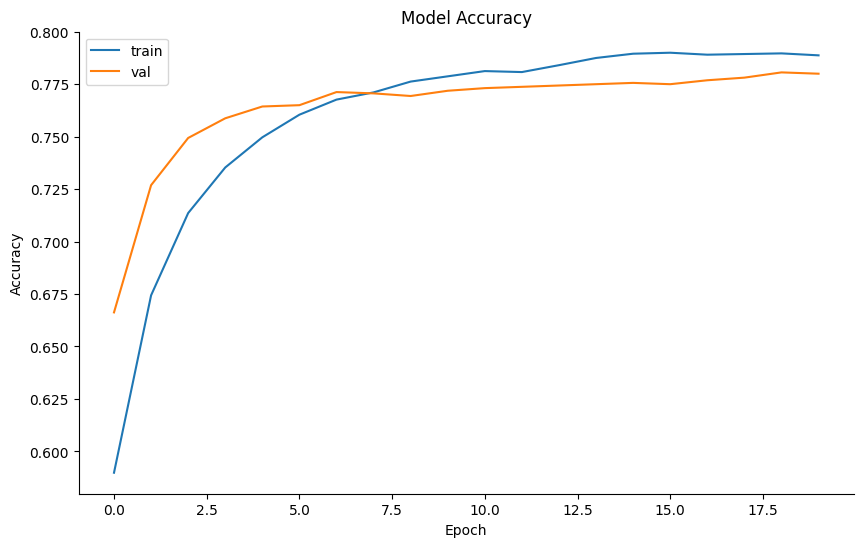

In [142]:
import matplotlib.pyplot as plt
plt.figure(figsize =(10, 6))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [143]:
x_mean_test=[]
for doc in x_test_vec:
    x_mean_test.append(np.mean(doc,axis=0))

In [144]:
x_mean_test=tf.convert_to_tensor(x_mean_test, dtype='float32')
print(x_mean_test.shape)

(2000, 300)


In [145]:
pred_y = model.predict(x_mean_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [146]:
pred_y[0:10]

array([[0.77520955],
       [0.18204355],
       [0.93518454],
       [0.5996976 ],
       [0.54871345],
       [0.73453915],
       [0.79014224],
       [0.45517328],
       [0.60006964],
       [0.18204355]], dtype=float32)

In [147]:
y_pred = (pred_y >= 0.5).astype(int)

In [148]:
y_pred[0:10]

array([[1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0]])

In [149]:
y_test[0:10]

1603    1
8713    0
4561    1
6600    1
2558    1
7642    0
8912    1
3319    0
6852    0
1366    0
Name: LabelSentiment, dtype: int64

In [150]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72       814
           1       0.80      0.81      0.81      1186

    accuracy                           0.77      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.77      0.77      0.77      2000



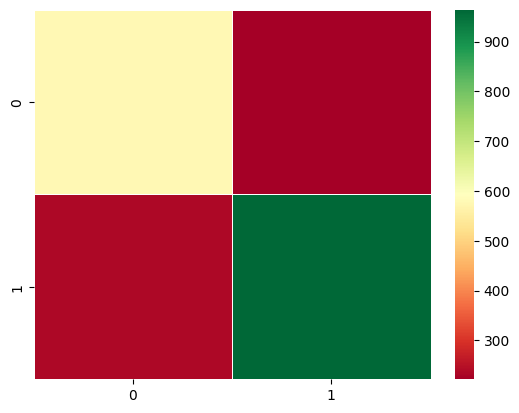

In [151]:
ax = sns.heatmap(confusion_matrix(y_pred, y_test), linewidth=0.5,cmap='RdYlGn')
plt.show()